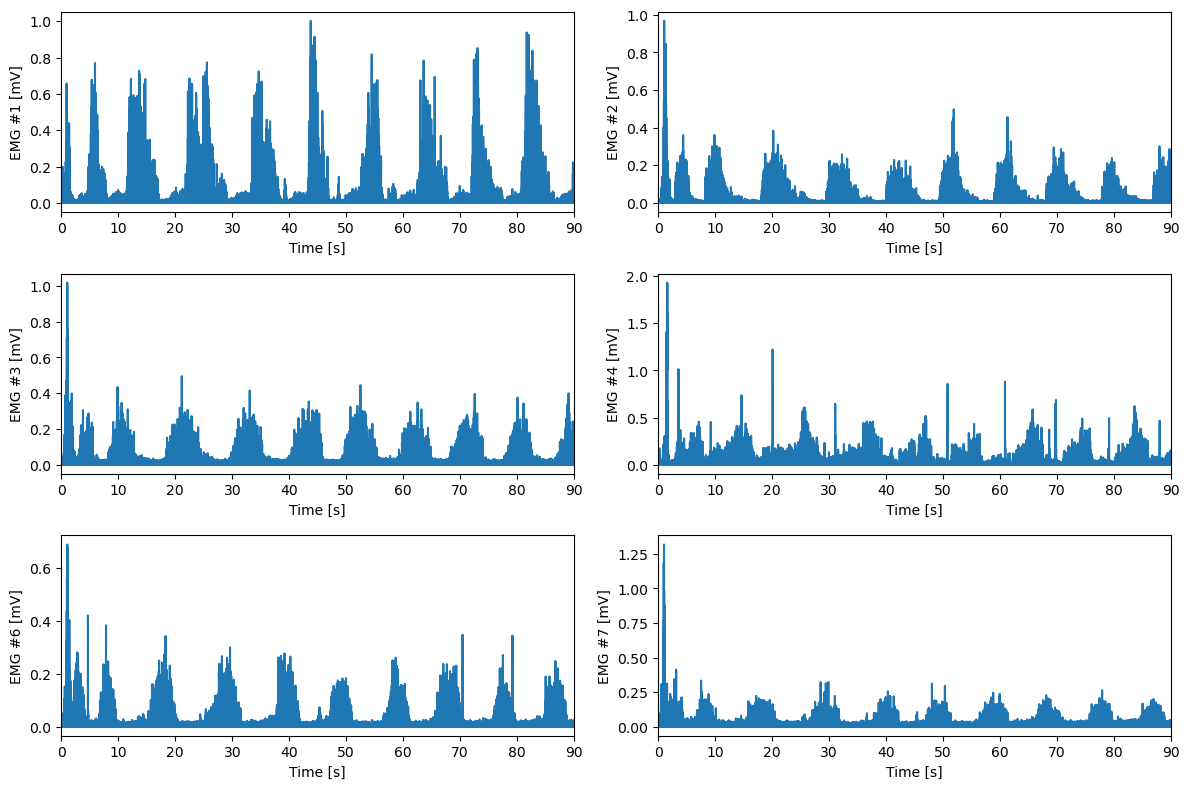

In [10]:
"""Plot recorded EMG signal

Here, 1) offset removal, 2) full-wave rectification, and 3.1) smoothing with LPF 3.2) smoothing with integral are implemented.
In default, 1), 2), and 3.1) are enabled and muscle activities will be plotted.
You can also see the raw data as well as data in process by commenting out these processes.

Please try changing filter parameters/methods and check results.
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal


def main():
    # Setup variables
    t0 =  0.0                        # time of the beginning of the plot [s] (this time is included)
    t1 = 90.0                        # time of the end of the plot [s] (this time is NOT included!)
    filename = "emg1.csv"             # filename of EMG data
    figname = "../results/assignment1/rect_only"  # filename of the output figure

    # Load an EMG data.
    # Here, Only columns that indicate time (column #0) or EMG data (column #1, 21, ..., 101) are loaded.
    # The time was recorded by each sensor, but they were almost the same values
    # (sampling intervals are 0.9 ms plus or minus 0.01 ms),
    # so one of them is taken out and applied for the entire data for usability.
    df = pd.read_csv(filename, usecols=[0, 1, 21, 41, 61, 81, 101])

    # Remove not-available values in the end of the time column
    df = df.dropna()

    # Extract time and EMG data separately
    times = df.values[:, 0]          # time [s]
    data  = df.values[:, 1:] * 1000  # EMG values [mV]

    # Process the EMG data
    data = remove_offset(data)                       # 1) Remove offset values
    data = rectify(data)                             # 2) Rectify the data
    # data = lpf(data, times, fc=4)                    # 3.1) Apply low-pass filter
    # data = integrate(data, times, window_size=2000)   # 3.2) Integrate the data

    # Compute plot range in x-axis (i.e., time-axis)
    r0 = np.where(times >= t0)[0][0]   # start index
    r1 = np.where(times <= t1)[0][-1]  # final index (not included)

    # Plot the data
    fig = plt.figure(figsize=(12, 8))
    for i in range(6):
        ax = fig.add_subplot(3, 2, i+1)
        ax.plot(times, data[:, i])
        ax.set_xlabel("Time [s]")
        if i >= 4:
            ax.set_ylabel("EMG #" + str(i+2) + " [mV]")
        else:
            ax.set_ylabel("EMG #" + str(i+1) + " [mV]")
        ax.set_xlim((times[r0], times[r1]))
    fig.tight_layout()

    # Save the figure
    plt.savefig(figname)

    # Show the figure
    plt.show()


def remove_offset(data):
    """Remove offset from the EMG data by subtracting mean values.
    """
    means = np.mean(data, axis=0)
    data_centralized = data - means
    return data_centralized


def rectify(data):
    """Apply full-wave rectification to EMG data.
    """
    # Full-wave rectification can be done simply by the absolute value function.
    data_rectified = np.abs(data)

    # Optional half-wave rectification code
    #data_rectified = np.where(data > 0, data, 0.0)
    return data_rectified


def lpf(data, times, fc):
    """Apply a low-pass filter (LPF).

    In this function, the LPF is applied twice: once forward and once backward.
    The resultant filter has zero phase and a filter order twice that of the original.

    fc: cutoff frequency of LPF [Hz]
    """
    # Setup constants
    n = 2               # order of a LPF. Note that the resultant order is doubled as the LPF is applied twice.
    fs = 1.0 / 9e-4     # sampling frequency [Hz]. Here, the sampling interval 0.9 ms is hard-coded.
    Wn = fc / (fs*0.5)  # cutoff frequency normalized by Nyquist frequency

    # Get numerator (b) and denominator (a) polynomials of the 2nd-order IIR Butterworth digital low-pass filter
    b, a = signal.butter(n, Wn, btype="lowpass")

    # Apply the LPF.
    # Here, LPF is applied twice: once forward and once backward.
    # This is equivalent to an 4th-order zero-phase filter.
    data_filtered = signal.filtfilt(b, a, data, axis=0)

    return data_filtered


def integrate(data, times, window_size):
    """Apply integration with given window size.

    In this function, integral is implemented by the discrete convolution function.
    Also, the result of integral is divided by the window size (thus, actually, this process is equivalent to moving average.)

    window_size: window size for integral (number of samples in a integral range)
    """
    # Setup constants
    v = np.ones(window_size) / window_size  # patch for convolution

    # Initialize the result data
    data_smoothed = np.empty_like(data)

    # Compute the integral for each column as convolve() cannot handle multiple columns at once.
    for i in range(data.shape[1]):
        data_smoothed[:, i] = np.convolve(data[:, i], v, mode="same")

    return data_smoothed


if __name__ == "__main__":
    main()
